# HW-DMD metro OD matrices forecasting

In [1]:
from functions import *
import time

data = loadmat('..//..//data//OD_3m.mat')
data = data['OD']
data = remove_weekends(data, start=5)


train_idx = start_end_idx('2017-07-03', '2017-07-28', weekend=False, night=False)
validate_idx = start_end_idx('2017-07-31', '2017-08-11', weekend=False, night=False)
test_idx = start_end_idx('2017-08-14', '2017-08-25', weekend=False, night=False)
train_data = data[:, train_idx]
test_data = data[:, test_idx]
validate_data = data[:, validate_idx]

flow0 = od2flow(data)
flow = np.zeros((flow0.shape[0]*2, flow0.shape[1]), dtype=flow0.dtype)
flow[0:flow0.shape[0], :] = flow0
flow[flow0.shape[0]:, 1:] = flow0[:, 0:-1]

m_train = train_idx.shape[0]
m_validate = validate_idx.shape[0]

## Parameter tuning
### Select proper time lags

In [1]:
h_selected = []
bs = 36
h_cadidate = list(range(3, 37))
e_best = 1000
e_history = []
ef_history = []
# Incremental update
t0 = time.time()
while True:
    e_current = []
    if len(h_selected)>=15:
        break
    for current_h in h_cadidate:
        h = h_selected + [current_h]
        model1 = HWDMD(h, 100, 100, 1, bs=bs)
        model1.fit(train_data, flow[:, max(h)-1:m_train-1])
        P1 = np.zeros(validate_data.shape)
        for i in range(int(validate_idx.shape[0]/bs)):
            day_idx = validate_idx[i * bs:(i * bs + bs)]
            p1 = model1.apply(data[:, day_idx], features=flow[:, day_idx-1], return_fit=True)
            P1[:, (i * bs):(i * bs + bs)] = p1
            X, Y = stagger_data(data[:, day_idx[0]-max(h): day_idx[-1]+1], h)
            X = np.concatenate([X, flow[:, day_idx-1]])
            model1.update_model(X, Y)
        e_current.append(RMSE(validate_data, P1))

    if min(e_current)>e_best:
        break
    e_best = min(e_current)
    e_history.append(e_best)
    current_selected_h = h_cadidate[np.argmin(e_current)]
    h_selected = h_selected + [current_selected_h]
    h_cadidate.remove(current_selected_h)
    print('Add {} at {}s, rmse: {}.'.format(current_selected_h, time.time() - t0, e_best))
    if len(h_cadidate)==0:
        break

NameError: name 'time' is not defined

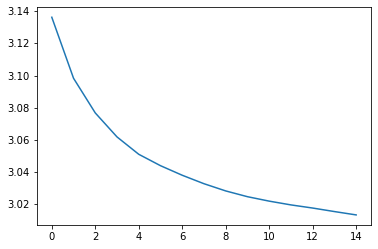

In [3]:
%matplotlib inline
plt.plot(e_history)

### Select ranks for $r_X$ and $r_Y$ 

In [4]:
m_train = train_idx.shape[0]
m_validate = validate_idx.shape[0]

bs = 36
h = [36, 33, 28, 19,8, 3, 30, 35, 4, 14]

tune_rank = np.zeros((9,9))
for x,rx in enumerate(range(20, 110, 10)):
    for y,ry in enumerate(range(20, 110, 10)):
        model1 = HWDMD(h, rx, ry, 1, bs=bs)
        model1.fit(train_data, flow[:, max(h)-1:m_train-1])
        P1 = np.zeros(validate_data.shape)
        for i in range(int(validate_idx.shape[0]/bs)):
            day_idx = validate_idx[i * bs:(i * bs + bs)]
            p1 = model1.apply(data[:, day_idx], features=flow[:, day_idx-1], return_fit=True)
            P1[:, (i * bs):(i * bs + bs)] = p1
            X, Y = stagger_data(data[:, day_idx[0]-max(h): day_idx[-1]+1], h)
            X = np.concatenate([X, flow[:, day_idx-1]])
            model1.update_model(X, Y)
        tune_rank[y,x] = RMSE(validate_data, P1)
        print('Finished rx={}, ry={}, rmse={}'.format(rx, ry, RMSE(validate_data, P1)))

Finished rx=20, ry=20, rmse=3.2673263001861748
Finished rx=20, ry=30, rmse=3.2480008710919765
Finished rx=20, ry=40, rmse=3.244838914159505
Finished rx=20, ry=50, rmse=3.2433776659655695
Finished rx=20, ry=60, rmse=3.2429840045448595
Finished rx=20, ry=70, rmse=3.24287923077492
Finished rx=20, ry=80, rmse=3.24290225785158
Finished rx=20, ry=90, rmse=3.242864023827199
Finished rx=20, ry=100, rmse=3.242856465359819
Finished rx=30, ry=20, rmse=3.1507621012189393
Finished rx=30, ry=30, rmse=3.120085004203859
Finished rx=30, ry=40, rmse=3.113940597461114
Finished rx=30, ry=50, rmse=3.110754798575397
Finished rx=30, ry=60, rmse=3.110128668653824
Finished rx=30, ry=70, rmse=3.1100227745225895
Finished rx=30, ry=80, rmse=3.109967841408791
Finished rx=30, ry=90, rmse=3.1101732893846235
Finished rx=30, ry=100, rmse=3.1101743379646223
Finished rx=40, ry=20, rmse=3.1188319075054927
Finished rx=40, ry=30, rmse=3.082494924256511
Finished rx=40, ry=40, rmse=3.0755267543522833
Finished rx=40, ry=50, r

### Select $\rho$

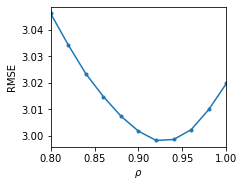

In [5]:
# Select the rho
h = [36, 33, 28, 19,8, 3, 30, 35, 4, 14]
bs =36
rmse_list = []
for rho in np.linspace(0.8, 1, 11):
    model1 = HWDMD(h, 100, 50, rho, bs=bs)
    model1.fit(train_data, flow[:, max(h)-1:m_train-1])
    P1 = np.zeros(validate_data.shape)
    for i in range(int(validate_idx.shape[0]/bs)):
        day_idx = validate_idx[i * bs:(i * bs + bs)]
        p1 = model1.apply(data[:, day_idx], features=flow[:, day_idx-1], return_fit=True)
        P1[:, (i * bs):(i * bs + bs)] = p1
        X, Y = stagger_data(data[:, day_idx[0]-max(h): day_idx[-1]+1], h)
        X = np.concatenate([X, flow[:, day_idx-1]])
        model1.update_model(X, Y)
    rmse_list.append(RMSE(validate_data, P1))

fig, ax = plt.subplots(figsize=(3.5, 2.7))
ax.plot(np.linspace(0.8,1,11), rmse_list,'.-')
ax.set_ylabel('RMSE')
ax.set_xlabel('$\\rho$')
ax.set_xbound([0.8,1])
fig.set_tight_layout(0.01)

## Test the model and the online update algorithm
The selected hyper-parameters are:
- time lag = [36, 33, 28, 19,8, 3, 30, 35, 4, 14]
- rankx = 100, ranky=50
- $\rho$=0.92

### Online update

In [9]:
h = [36, 33, 28, 19,8, 3, 30, 35, 4, 14]
bs = 36
t0 = time.time()
model1 = HWDMD(h, 100, 50, 0.92, bs=bs)
model1.fit(train_data, flow[:, max(h)-1:m_train-1])
test_idx2 = np.arange(validate_idx[0], data.shape[1])
P1 = np.zeros((data.shape[0], len(test_idx2)))  # To store predicted values
for i in range(int(test_idx2.shape[0]/bs)):
    day_idx = test_idx2[i * bs:(i * bs + bs)]
    p1 = model1.apply(data[:, day_idx], features=flow[:, day_idx-1], return_fit=True)  # Forecast
    P1[:, (i * bs):(i * bs + bs)] = p1
    
    # Update model
    X, Y = stagger_data(data[:, day_idx[0]-max(h): day_idx[-1]+1], h)
    X = np.concatenate([X, flow[:, day_idx-1]])
    model1.update_model(X, Y)

print("Total RMSE {}\n Time {}".format(RMSE(data[:, test_idx2], P1), time.time()-t0))

Total RMSE 3.0372455824503954
 Time 61.441123723983765


### Not update

In [11]:
# HWDMD not updated version
t0 = time.time()
model2 = HWDMD(h, rx=100, ry=50, rho=0.92, bs=bs)
model2.fit(train_data, flow[:, max(h)-1:m_train-1])

P2 = model2.apply(data[:, validate_idx[0]:], features=flow[:, (validate_idx[0]-1):-1], return_fit=True)
np.savez_compressed('..//..//data//OD_HWDMD_no_update_2boarding.npz', data=P2)
print("Total RMSE {}\n Time {}".format(RMSE(data[:, test_idx2], P2), time.time()-t0))

Total RMSE 3.510742843470735
 Time 35.31679725646973


### Retrain using the entire data

In [12]:
t0=time.time()
model3 = HWDMD(h, rx=100, ry=50, rho=0.92, bs=bs)
model3.fit(data[:, :validate_idx[0]], flow[:, max(h)-1:validate_idx[0]-1])
P3 = np.zeros((data.shape[0], len(test_idx2)))  # To store predicted values
for i in range(int(test_idx2.shape[0]/bs)):
    day_idx = test_idx2[i * bs:(i * bs + bs)]
    p3 = model3.apply(data[:, day_idx], features=flow[:, day_idx-1], return_fit=True)  # Forecast
    P3[:, (i * bs):(i * bs + bs)] = p3
    
    # Retrain the model. If input data too large, use memory_save mode
    if i <= 21:
        memory_save = False
    else:
        memory_save = True
    model3.fit(data[:, :(day_idx[-1]+1)], features=flow[:, max(h)-1:day_idx[-1]], memory_save_mode=memory_save)

print("Total RMSE {}\n Time {}".format(RMSE(data[:, test_idx2], P3), time.time()-t0))

Total RMSE 3.0624481423885084
 Time 2764.030907392502


### Retrain using the entire data, not weight

In [13]:
t0 = time.time()
model4 = HWDMD(h, rx=100, ry=50, rho=1, bs=bs)
model4.fit(data[:, :validate_idx[0]], flow[:, max(h)-1:validate_idx[0]-1])
P4 = np.zeros((data.shape[0], len(test_idx2)))  # To store predicted values
for i in range(int(test_idx2.shape[0]/bs)):
    day_idx = test_idx2[i * bs:(i * bs + bs)]
    p4 = model4.apply(data[:, day_idx], features=flow[:, day_idx-1], return_fit=True)  # Forecast
    P4[:, (i * bs):(i * bs + bs)] = p4
    
    # Retrain the model. If input data too large, use memory_save mode
    if i <= 21:
        memory_save = False
    else:
        memory_save = True
    model4.fit(data[:, :(day_idx[-1]+1)], features=flow[:, max(h)-1:day_idx[-1]], memory_save_mode=memory_save)

print("Total RMSE {}\n Time {}".format(RMSE(data[:, test_idx2], P4), time.time()-t0))

Total RMSE 3.124670516145434
 Time 2660.975035429001


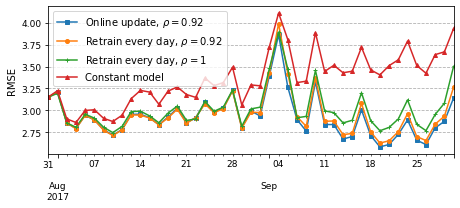

In [14]:
rmse_p1 = RMSE(data[:, test_idx2], P1, axis=0)
rmse_p1 = rmse_p1.reshape((36, -1), order='F')
rmse_p1 = rmse_p1.mean(axis=0)

rmse_p2 = RMSE(data[:, test_idx2], P2, axis=0)
rmse_p2 = rmse_p2.reshape((36, -1), order='F')
rmse_p2 = rmse_p2.mean(axis=0)

rmse_p3 = RMSE(data[:, test_idx2], P3, axis=0)
rmse_p3 = rmse_p3.reshape((36, -1), order='F')
rmse_p3 = rmse_p3.mean(axis=0)

rmse_p4 = RMSE(data[:, test_idx2], P4, axis=0)
rmse_p4 = rmse_p4.reshape((36, -1), order='F')
rmse_p4 = rmse_p4.mean(axis=0)

idx = pd.date_range(start='2017-07-31', end='2017-09-30')
idx = idx[idx.weekday<5]
result = pd.DataFrame(index=idx, data = {'Online_update':rmse_p1, 'entire_update':rmse_p3, 'entire_update_equal':rmse_p4,  'No_update':rmse_p2})

fig, ax = plt.subplots(figsize=(6.5, 3))
result.plot(ylabel='RMSE', style=['s-', 'o-', '+-', '^-'], ms=4, ax=ax, legend=False, fontsize=9)
ax.legend((r'Online update, $\rho=0.92$', r'Retrain every day, $\rho=0.92$', r'Retrain every day, $\rho=1$', r'Constant model'))
fig.set_tight_layout(0.01)
ax.grid(axis='y', linestyle='--')